# Preparing data for ResNet
Matteo Sabadin, last update: Sun 20 Nov

Sections:
- Part 1 - Initialization
- Part 2 - Plot the Spectrograms
- Part 3 - Transofrm spectrograms into bidimentional matrices.

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

## Part 1 - Initialization

Download and upload the mros library from github. Check all requirements.

Requirements
- python==3.10
- librosa==0.9.2
- mne==1.2.1
- numpy==1.23.3
- scikit-learn==1.1.1
- pytorch==1.13.0
- pytorch-lightning==1.7.7
- rich==12.6.0
- ipympl
- pytest (for writing unit tests)

The library **mros-data** is downloaded in this environment as explained in the github. 

* mkdir <project_folder> 
* cd <project_folder> 
* git clone https://www.github.com/neergaard/mros-data.git 
* cd mros-data 
* pip install -e 

The data is downloaded from OneDrive.

In [1]:
import os
from pathlib import Path
os.chdir(Path(os.path.abspath("C:/Users/matte/Desktop/Project_Folder_git/mros-data/")))
from mros_data.datamodule import SleepEventDataModule
from mros_data.datamodule.transforms import STFTTransform

params = dict(
    data_dir="C:/Users/matte/Desktop/Project_Folder_git/lm",
    batch_size=16,
    n_eval=2,
    n_test=2,
    num_workers=0,
    seed=1337,
    events={"lm": "Leg movement"},
    window_duration=600,  # seconds
    cache_data=True,
    default_event_window_duration=[15],
    event_buffer_duration=3,
    factor_overlap=2,
    fs=64,
    matching_overlap=0.5,
    n_jobs=-1,
    n_records=10,
    picks=["legl", "legr"],
    # transform=MultitaperTransform(128, 0.5, 35.0, tw=8.0, normalize=True),
    transform=STFTTransform(
        fs=64, segment_size=int(4.0 * 64), step_size=int(0.125 * 64), nfft=1024, normalize=True
    ),
    scaling="robust",
)
dm = SleepEventDataModule(**params)
print(dm)

C:\Users\matte\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


SleepEventDataModule(data_dir=WindowsPath('C:/Users/matte/Desktop/Project_Folder_git/lm'), n_test=2, n_eval=2, seed=1337, events={'lm': 'Leg movement'}, window_duration=600, cache_data=True, default_event_window_duration=[15], event_buffer_duration=3, factor_overlap=2, fs=64, matching_overlap=0.5, n_jobs=-1, n_records=10, picks=['legl', 'legr'], transform=<mros_data.datamodule.transforms.stft_transform.STFTTransform object at 0x0000018580DDB460>, scaling='robust', batch_size=16, num_workers=0)


Checkpoint 1. Now all the h5 files have been downloaded, the packages have been updated and the mros_data library is accessible from the code. The only issues are:
- python version is not 3.10 but 3.9.12 instead.

## Part 2 - Plot Spectrograms
Plot spectrograms for both channels, for each element.

### Split dataset into train/eval partitions

In [2]:
# The datamodule will split the dataset into train/eval partitions by calling the setup() method.
dm.setup('fit')
train_dl, eval_dl = dm.train_dataloader(), dm.val_dataloader()

# The dataloaders are generators, ie. we can iterate over them using a for-loop.
for i, (data, events, records, *_) in enumerate(train_dl):
    if i < 1:
        print(f'Batch size: {data.shape[0]} | No. channels: {data.shape[1]} | No. timepoints {data.shape[-1]} | No. events: {sum([ev.shape[0] for ev in events])} | Data sample size: {list(data.shape[1:])} ')
    break

Using cache for data prep: C:\Users\matte\Desktop\Project_Folder_git\mros-data\data\.cache


100%|██████████| 6/6 [00:00<00:00, 27.78it/s]


Using cache for data prep: C:\Users\matte\Desktop\Project_Folder_git\mros-data\data\.cache


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Batch size: 16 | No. channels: 2 | No. timepoints 4801 | No. events: 294 | Data sample size: [2, 513, 4801] 


#### Accessing the underlying datasets

In [3]:
# The underlying data windows can be accessed by indexing into the dataset. This will call the __getitem__() method and yield the signals, and associated events. 
# The events' start times and durations are normalized to the window, ie. an event with elements (0.1, 0.025) in a 10 min window will start at 10 min x 60 s / min x 0.1 = 60 s , and will last 10 min x 60 s / min x 0.025 = 15 s.
train_ds = dm.train
eval_ds = dm.eval ## added by MS
batch = train_ds[1]
record = batch['record']
data = batch['signal']
events = batch['events']
print(batch.keys())
print(f'Record: {record} | No. channels: {data.shape[0]} | No. timepoints: {data.shape[1]} | No. events: {len(events)}')

dict_keys(['signal', 'events', 'stages', 'record', 'localizations_target', 'classifications_target'])
Record: mros-visit1-aa0012 | No. channels: 2 | No. timepoints: 513 | No. events: 15


What I understand:
- train_ds[] contains the training set, one element in each position. Length: 700
- eval_ds[] contains the test set, one element in each position. Length: 280

Each element of the previous two, contains the following elements:
- signal
- events
- stages
- record
- localizations_target
- classifications_target

#### Plotting signals
Signals can be plotted using *.plot_signals*. train_ds or eval_ds can be plotted. The number used in the function represents the correspondent element in the dataset. Below, the last element for each dataset are plotted.

In [4]:
print("Training set has %i elements." %len(train_ds))
print("Test set has %i elements." %len(eval_ds))

Training set has 700 elements.
Test set has 280 elements.


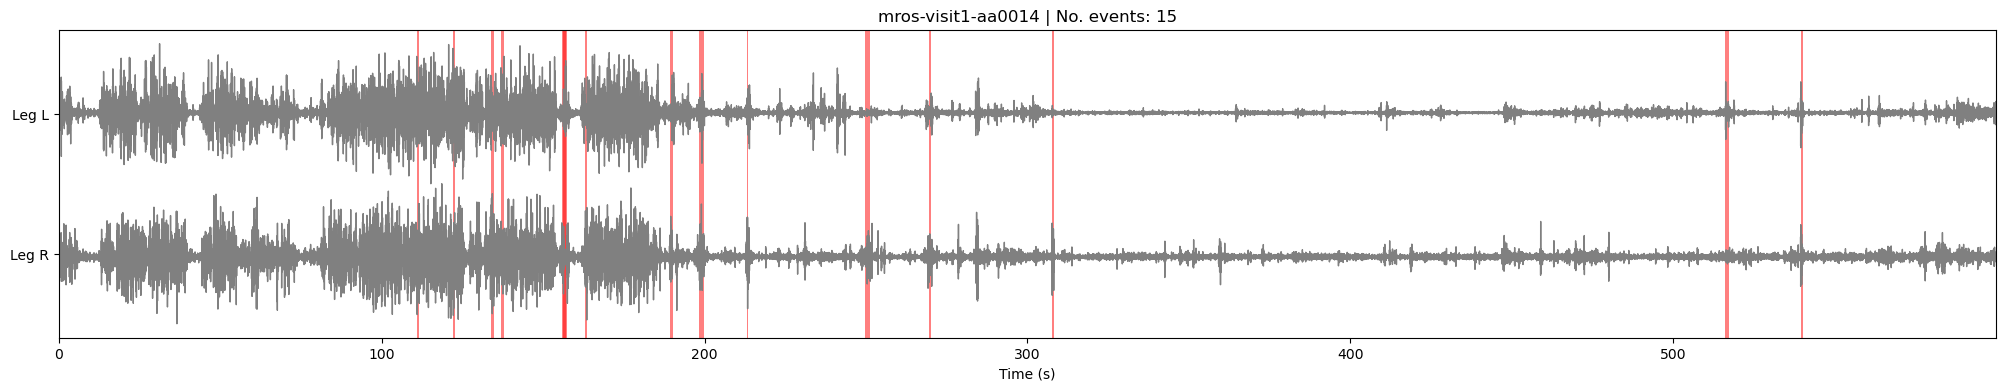

In [5]:
train_ds.plot_signals(699, channel_names=['Leg L', "Leg R"])

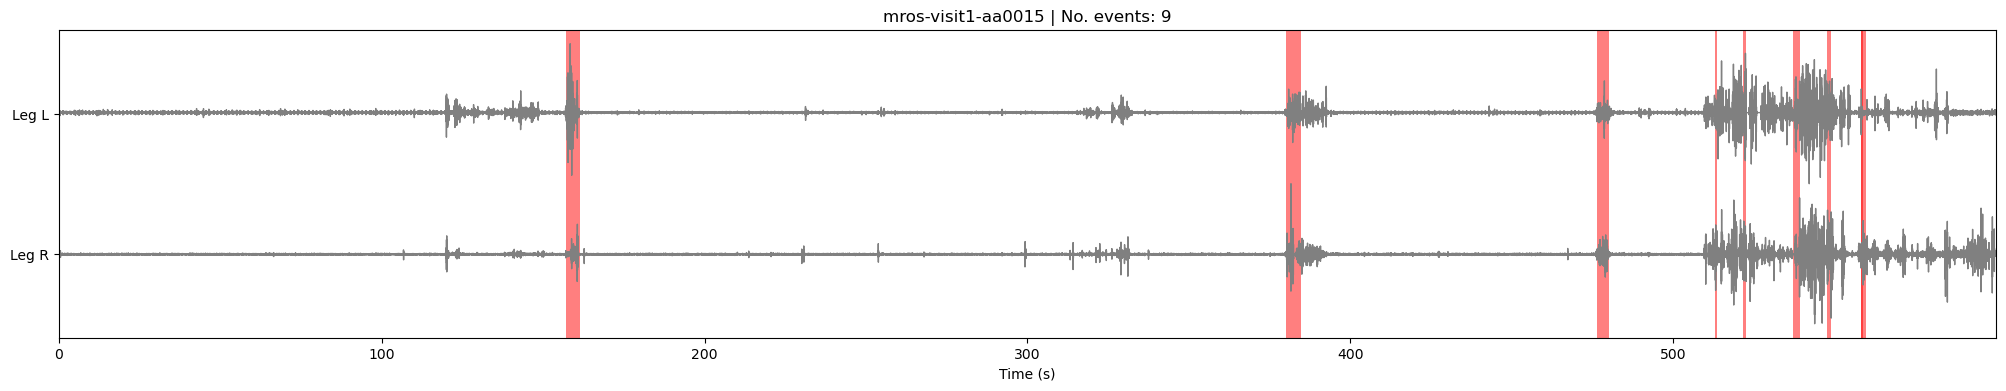

In [6]:
eval_ds.plot_signals(279, channel_names=['Leg L', "Leg R"])

#### Transforming data on the fly
The spectrogams are obtained usign the *transform* method. Below, the last elements of each datasets are represented as spectrograms.

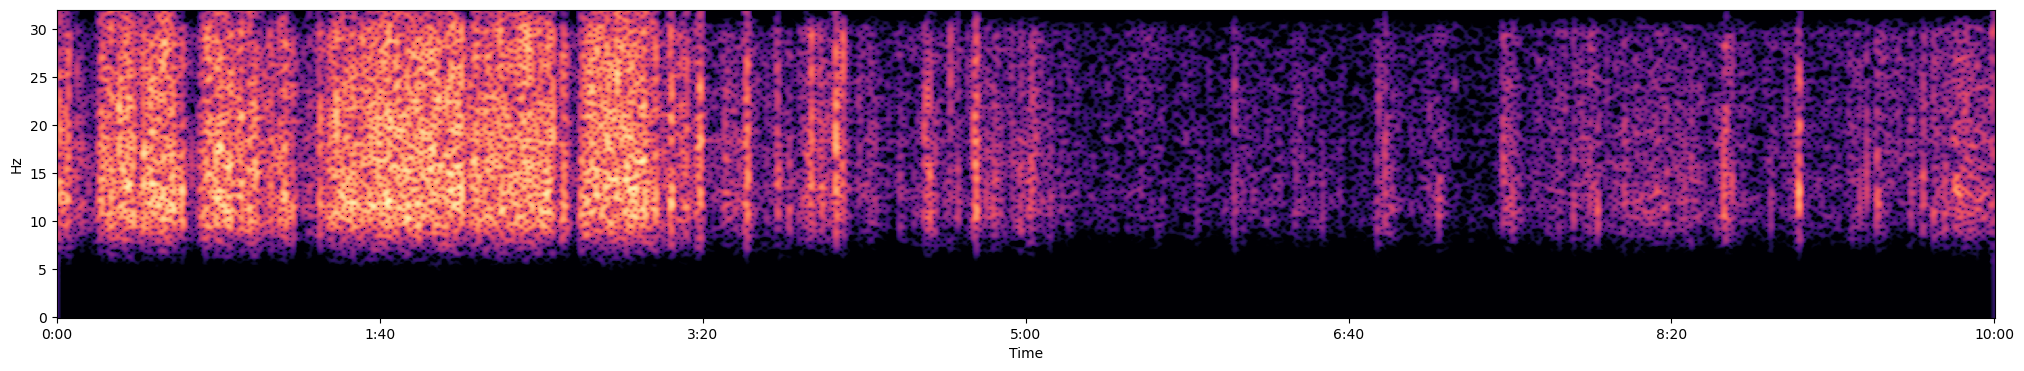

In [7]:
train_ds.plot_spect(699, channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)

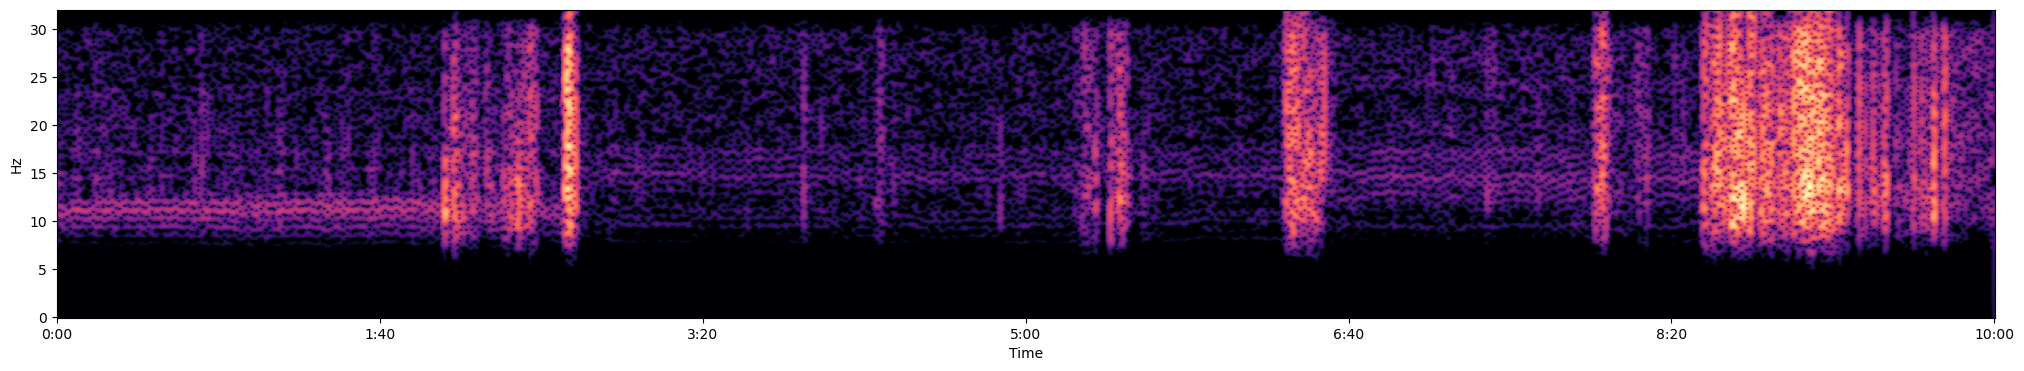

In [8]:
eval_ds.plot_spect(279, channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)

Below, the two plots have been combined into one using the *.plot* method available.

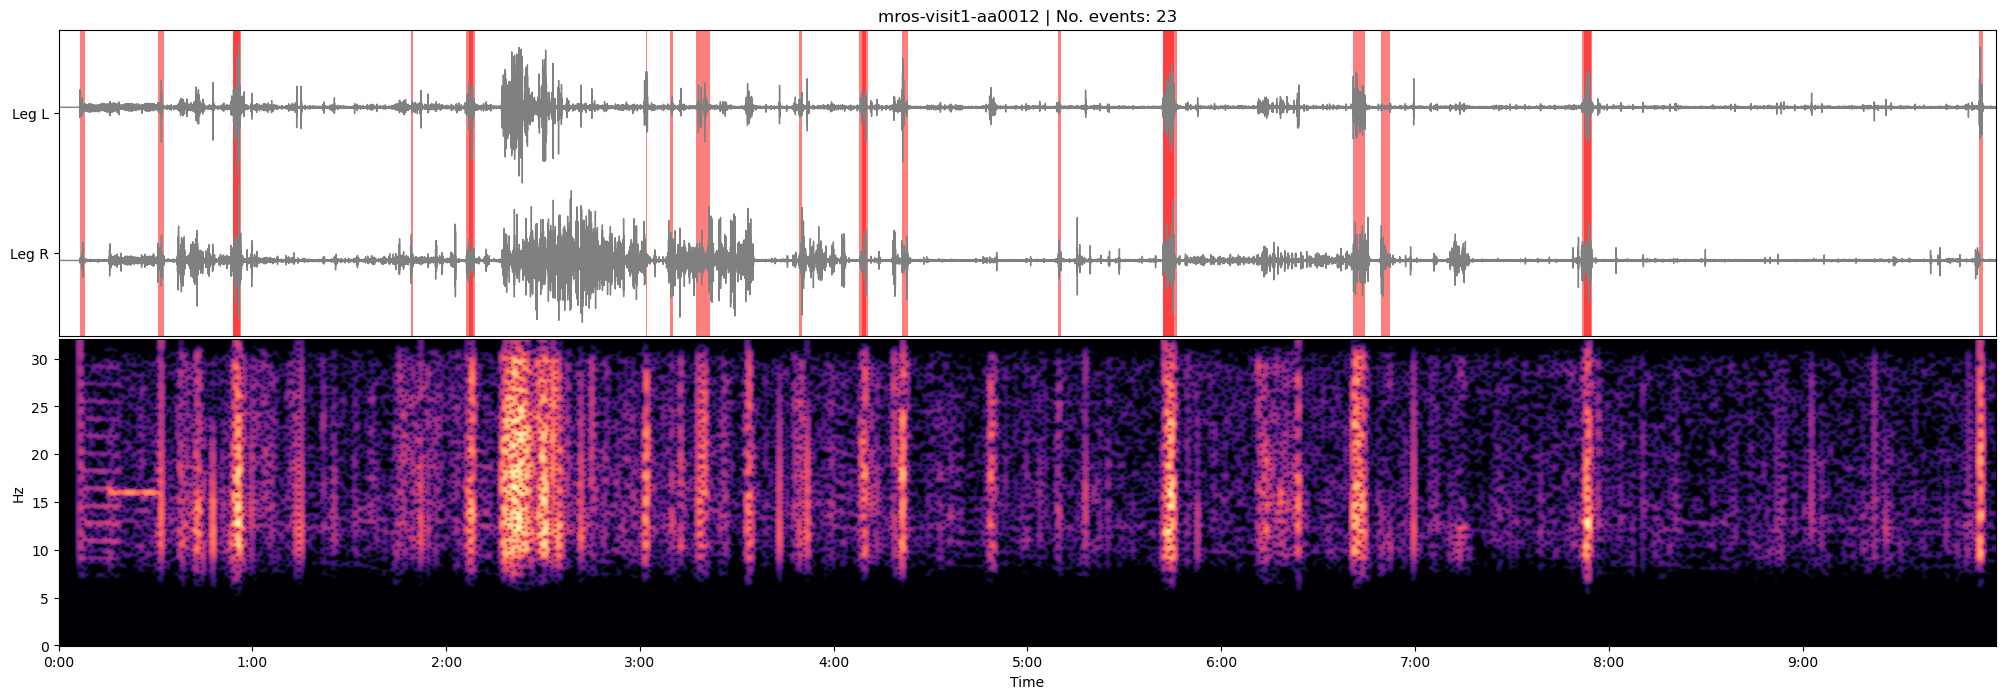

In [9]:
train_ds.plot(0, channel_names=['Leg L', 'Leg R'], channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)

## Part 3 - Transofrm spectrograms into bidimentional matrices.
Assumptions: 
- The spectrogarms are representing both channels.

In this section, the spectrograms will be transformed into bidimentional matrices, and saved in an external folder. In order to do so, the file

mros_data > datamodule > mixins > plotting_mixin.py 

was modified. It now contains a method called get_2dmatrix() that works exactly as the method plot_spect(), but his time instead of plotting the spectrogram, it returns the matrix representation of the spectrogram.

In [10]:
spectrogram = train_ds.get_2Dmatrix(0, channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)

In [11]:
print("Shape: ", spectrogram.shape)
print(spectrogram)

Shape:  (513, 4801)
[[0.07434388 0.07434388 0.07434388 ... 0.07434388 0.07434388 0.07434388]
 [0.07434388 0.07434388 0.07434388 ... 0.07434388 0.07434388 0.07434388]
 [0.07434388 0.07434388 0.07434388 ... 0.07434388 0.07434388 0.07434388]
 ...
 [0.07434388 0.07434388 0.07434388 ... 0.07434388 0.07434388 0.07434388]
 [0.07434388 0.07434388 0.07434388 ... 0.07434388 0.07434388 0.07434388]
 [0.07434388 0.07434388 0.07434388 ... 0.07434388 0.07434388 0.07434388]]


In [12]:
for ik_index in range(0,2):
    print(ik_index)
    print(eval_ds.get_2Dmatrix(ik_index, channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024))

0
[[0.15681648 0.15681648 0.15681648 ... 0.15681648 0.15681648 0.15681648]
 [0.15681648 0.15681648 0.15681648 ... 0.15681648 0.15681648 0.15681648]
 [0.15681648 0.15681648 0.15681648 ... 0.15681648 0.15681648 0.15681648]
 ...
 [0.15681648 0.15681648 0.15681648 ... 0.44854492 0.40138936 0.3598775 ]
 [0.15681648 0.15681648 0.15681648 ... 0.38301745 0.30390593 0.2472721 ]
 [0.15681648 0.15681648 0.15681648 ... 0.33707818 0.18118066 0.15681648]]
1
[[0.14024436 0.14024436 0.14024436 ... 0.14024436 0.14024436 0.14024436]
 [0.14024436 0.14024436 0.14024436 ... 0.14024436 0.14024436 0.14024436]
 [0.14024436 0.14024436 0.14024436 ... 0.14024436 0.14024436 0.14024436]
 ...
 [0.1729446  0.1698592  0.16340229 ... 0.14024436 0.14024436 0.14024436]
 [0.17028436 0.16768762 0.16283564 ... 0.14024436 0.14024436 0.14024436]
 [0.16940464 0.16704834 0.16287196 ... 0.14024436 0.14024436 0.14024436]]


The 2D matrices are fairly quick to obtain.

Just to be sure, below, we have the original spectrogram, obtained from the relative function in the library and the recreated spectrogram from the 2D matrix obtained by the new function, and then transformed into a spectrogram using the *librosa.display.specshow()* function.

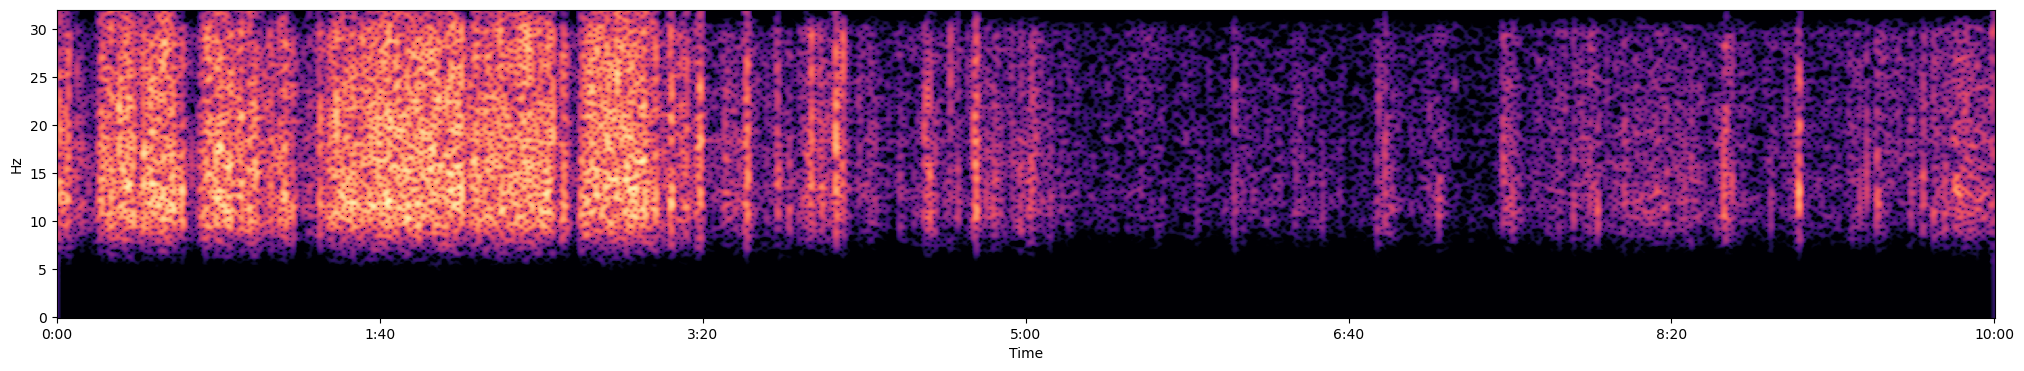

In [46]:
train_ds.plot_spect(699, channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)

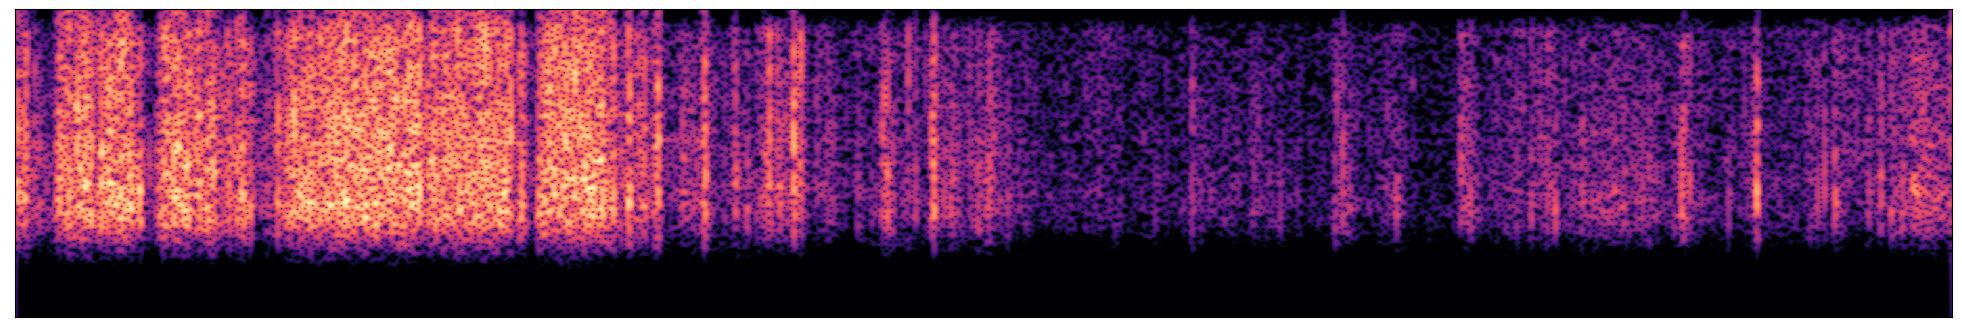

In [47]:
from librosa.display import specshow
fig, ax = plt.subplots(figsize=(25, 4))
spectrogram = train_ds.get_2Dmatrix(699, channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)
specshow(spectrogram, sr=10000, win_length=int(4.0 * train_ds.fs), hop_length=int(0.125 * train_ds.fs), ax=ax, n_fft=1024)
plt.show()

They are the same image. 

Now we can transform the 2Dmatrix into a 2D Tensor. 

In [54]:
tensor_1 = torch.tensor(spectrogram)
print(tensor_1.shape)
print(spectrogram.shape)
tensor_1

torch.Size([513, 4801])
(513, 4801)


tensor([[0.4392, 0.4374, 0.4323,  ..., 0.3971, 0.4016, 0.4028],
        [0.4392, 0.4374, 0.4323,  ..., 0.3971, 0.4016, 0.4028],
        [0.4391, 0.4374, 0.4322,  ..., 0.3970, 0.4016, 0.4028],
        ...,
        [0.6481, 0.6727, 0.6923,  ..., 0.6185, 0.6233, 0.6246],
        [0.6479, 0.6724, 0.6917,  ..., 0.6183, 0.6228, 0.6240],
        [0.6479, 0.6723, 0.6915,  ..., 0.6183, 0.6227, 0.6238]])

Now we should take care of the target variables, I guess. 

And then we should transform the 2D tensor into a 3D tensor.